This notebook is a part of the Optical Tweezers experiment data anaysis procedure (Sebastian Kalos, Tengiz Ibrayev, March/ April 2021). In this part, we are not forcing stage motion but only take time-voltage series of QPD signal from a "free" bead in water, trapped in the tweezers. We calculate the Boltzmann constant (for each power level) via equipartition theorem (knowing the trap's stiffness and other parameters)

In [836]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
import statistics

In [516]:
xls_file = pd.ExcelFile("PSD_mar17.xlsx") #just load the excel file containing QPD data ("freely floating" bead, trapped in the tweezers)

In [531]:
#reading each sheet into a data frame
df_150mA = pd.read_excel(xls_file, '150mA')
df_200mA = pd.read_excel(xls_file, '200mA')
df_250mA = pd.read_excel(xls_file, '250mA')
df_300mA = pd.read_excel(xls_file, '300mA')
df_350mA = pd.read_excel(xls_file, '350mA')
df_400mA = pd.read_excel(xls_file, '400mA')

In [1027]:
frequency = 20 #Hz, frequency of oscillation we are forcing (triangular voltage input)
meas_len = 5 #5 seconds of measurement
time_display_start = 0 #x-axis start of all plots
time_display_stop = 0.2 #x-axis limit for all plots
workbook_name = "tweezers_data.xlsx"
temperature = 295 #Kelvin
temp_err = 10 #Kelvin

sheet_name = '2micron'
picked_power = 150 #mA

In [1028]:
#finding parameters (laser powers, QPD sensitivities, and stiffness values) in an excel file
tweezers_data_file = pd.ExcelFile(workbook_name)
df_tweezers = pd.read_excel(tweezers_data_file, sheet_name)
arr_tweezers = df_tweezers.to_numpy()
qpd_laser_powers = arr_tweezers[:,0]

qpd_sens = arr_tweezers[:,1]
qpd_sens_err = arr_tweezers[:,4]

stiffness_arr = arr_tweezers[:, 2]
stiffness_err = arr_tweezers[:,5]

In [1029]:
n_of_datapoints = len(df_150mA.index) #how many time values are taken?
time = np.arange(0,meas_len,meas_len/n_of_datapoints) #create a new array with time series

In [1030]:
#convert PSD measurement dataframe to numpy arrays (I lowkey hate to work with this dataframe format)
arr_150mA = df_150mA.to_numpy()
arr_200mA = df_200mA.to_numpy()
arr_250mA = df_250mA.to_numpy()
arr_300mA = df_300mA.to_numpy()
arr_350mA = df_350mA.to_numpy()
arr_400mA = df_400mA.to_numpy()

In [1031]:
stokes_laser_powers = np.array([150, 200, 250, 300, 350, 400])

laser_power_index = int(np.where(stokes_laser_powers == picked_power)[0])
laser_power_arrays = [arr_150mA, arr_200mA, arr_250mA, arr_300mA, arr_350mA, arr_400mA]
picked_dev = laser_power_arrays[laser_power_index]

In [1032]:
#load each column into an np array:
qpd_x = picked_dev[:,0]
qpd_y = picked_dev[:,1]
qpd_z = picked_dev[:,2]

Text(0, 0.5, 'QPD voltage (V)')

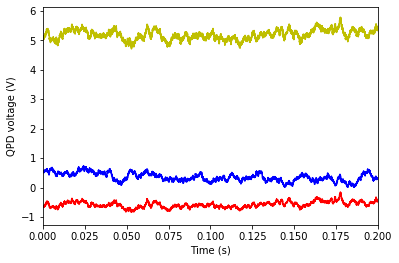

In [1033]:
#just plotting qpd voltage data versus time here
plt.plot(time, qpd_x, 'b')
plt.plot(time, qpd_y, 'r')
plt.plot(time, qpd_z, 'y')
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time (s)')
plt.ylabel('QPD voltage (V)')

In [1034]:
power_index = int(np.where(qpd_laser_powers == picked_power)[0])
sensitivity = qpd_sens[power_index] #microns/volt
sensitivity_STDEV = qpd_sens_err[power_index]

stiffness = stiffness_arr[power_index] *1E-6 #stifness in N/m
stiffness_STDEV = stiffness_err[power_index]*1E-6

print(sensitivity, " microns/volt qpd sensitivity at ", picked_power, " mA laser power (" + str(stiffness*1E6) + " pN/micron stiffness)")

0.01428024947102258  microns/volt qpd sensitivity at  150  mA laser power (15.228295886578 pN/micron stiffness)


In [1071]:
variance = statistics.variance(qpd_x)# variance of qpd voltage
pos_variance = variance *sensitivity* 1E-12 #converted into meters^2
pos_variance_ERR = pos_variance*(sensitivity_STDEV/sensitivity)

In [1072]:
def find_kb(pos_variance, pos_variance_ERR, stiffness, stiffness_ERR, temp, temp_ERR):
    #This function simply calculates the Boltzmann constant
    kb = stiffness * pos_variance / temp
    kb_STDEV = kb*np.sqrt((stiffness_ERR/stiffness)**2 + (pos_variance_ERR/pos_variance)**2 + (temp_ERR/temp)**2)
    return(kb, kb_STDEV)

In [1073]:
[kb, kb_STDEV] = find_kb(pos_variance, pos_variance_ERR, stiffness, stiffness_STDEV, temperature, temp_err)
print('{:0.3e}'.format(kb))
print('{:1.1e}'.format(kb_STDEV))

1.386e-23
3.7e-24


# This is the estimated Boltzmann constant and its STDEV!

In [1038]:
import openpyxl

# Here I write the boltzmann constant into the output excel file:
write_file = openpyxl.load_workbook(workbook_name) #handler for writing into an existing excel file
sheet = write_file.get_sheet_by_name(sheet_name) #get the name of the existing sheet

power_index = np.where(qpd_laser_powers == picked_power)[0][0] #find the index of the laser power used
sheet.cell(row=power_index+2, column=4).value = kb #write the average qpd sensitivity value next to the relevant laser power
sheet.cell(row=power_index+2, column=7).value = kb_STDEV

write_file.save(workbook_name) #save the excel file

ipykernel_launcher:5: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
